In [10]:

import keras.backend as K
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import nibabel as nib
import cv2

In [11]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}
IMG_SIZE=128
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [12]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [13]:
model = keras.models.load_model('model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [14]:
def predictByPath(flair_path,t1ce_path):
    
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    flair=nib.load(flair_path).get_fdata()
    
    ce=nib.load(t1ce_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(seg_path,flair_path,t1ce_path, start_slice = 70):
    gt = nib.load(seg_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(flair_path,t1ce_path)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(20, 50))
    f, axarr = plt.subplots(1,6, figsize = (20, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 788ms/step


<Figure size 2000x5000 with 0 Axes>

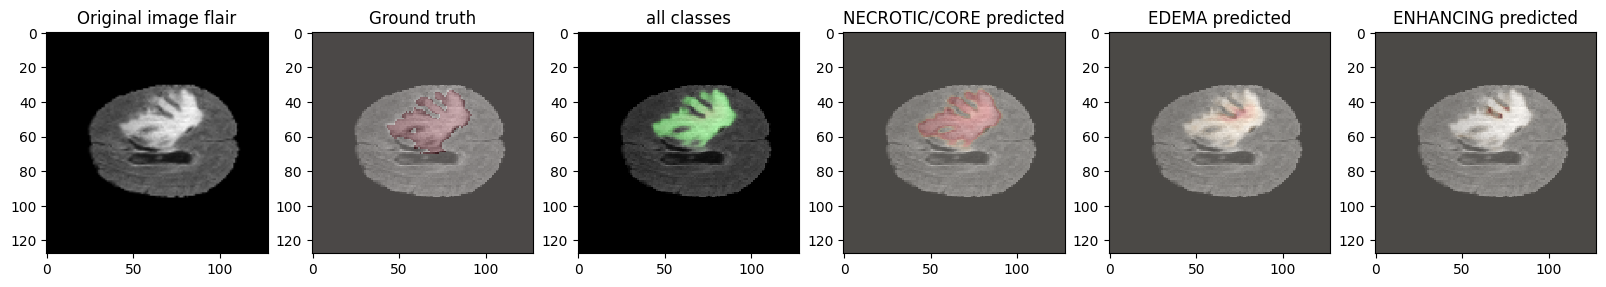

In [15]:
showPredictsById('BraTS20_Training_001_seg.nii','BraTS20_Training_001_flair.nii','BraTS20_Training_001_t1ce.nii', start_slice = 70)

In [2]:
!pip install git+https://github.com/miykael/gif_your_nifti

  Cloning https://github.com/miykael/gif_your_nifti to c:\users\admin\appdata\local\temp\pip-req-build-3hmtsb83
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached imageio-2.36.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached scikit_image-0.24.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached tifffile-2024.9.20-py3-none-any.whl.metadata (32 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached imageio-2.36.0-py3-none-any.whl (315 kB)
Using cached scikit_image-0.24.0-cp310-cp310-win_amd64.whl (12.9 MB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2024.9.20-py3-none-any.whl (228 kB)
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6707 sha256=e5b913d1955d1eabb1c277692571c48ab8c7126b7584abccfb15e680b9d129ff
  Sto

  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-3hmtsb83'


In [5]:
import gif_your_nifti.core as gif2nif
gif2nif.write_gif_normal('BraTS20_Training_001_flair.nii')

<img src="BraTS20_Training_001_flair.gif"/>